<a href="https://colab.research.google.com/github/Vladm0z/HSE-Bioinformatics/blob/main/Bioinformatics/MSc/PracBio/PracBio_0417.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install some dependencies

In [1]:
! pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.6 MB/s eta 0:00:00


In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from Bio import SeqIO
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from collections import Counter

#0. Load data

In [3]:
# https://github.com/rybinaanya/hse2025.git

!git clone https://github.com/rybinaanya/hse2025.git


Cloning into 'hse2025'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 4.49 MiB | 7.24 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
%cd hse2025

/content/hse2025


In [5]:
!ls

accessory_binary_genes.fa	  gene_presence_absence.csv
accessory_binary_genes.fa.newick  pan_genome_ref.emapper.annotations.tsv
core_gene_alignment.aln		  pan_genome_reference.fa
core_gene_alignment.tree	  README.md
df_genbank_helvet.tsv		  summary_statistics.txt


**Description of files**

`df_genbank_helvet.tsv`  =  metadata on lactobacillus strains

`pan_genome_ref.emapper.annotations.tsv` = functional annotation of the genes from the `pan_genome_reference.fa` obtained by EggNog mapper (online web service)

other fiels are part of the `Roary` output. `Roary` is a tool used for pangenome analysis https://sanger-pathogens.github.io/Roary/


first, genomes of lactobacillus were annotated using `Prokka`:
```
prokka --outdir ${out_dir} --prefix ${name} --force --locustag ${name[:20]} --cpus 4 ${fna_path}
```

then, resulting GFF3 files were directed to Roary for pangenome analysis:
```
roary -e -n -v prokka_output/*/*.gff -f roary_output
```




In [6]:
import pandas as pd

# Load files
# output of roary
gpa = pd.read_csv("gene_presence_absence.csv", low_memory=False)

#metadata for genomes
meta = pd.read_csv("df_genbank_helvet.tsv", sep="\t")

# functional annotation via EggNog for genomic sequences derived from Roary
eggnog = pd.read_csv("pan_genome_ref.emapper.annotations.tsv", sep='\t', comment='#', header=None)

In [7]:
column_names = [
    "query_name", "seed_eggNOG_ortholog", "evalue", "score", "eggNOG_taxonomy",
    "COG_OGs", "COG_category", "Description", "Preferred_name", "GOs",
    "EC", "KEGG_ko", "KEGG_Pathway", "KEGG_Module", "KEGG_Reaction",
    "KEGG_rclass", "BRITE", "KEGG_TC", "CAZy", "BiGG_Reaction", "Extra"
]

# Assign columns and extract key fields
eggnog.columns = column_names
eggnog.head()

,query_name,seed_eggNOG_ortholog,evalue,score,eggNOG_taxonomy,COG_OGs,COG_category,Description,Preferred_name,GOs,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,Extra
0,Lactobacillus_helvet_00001,326425.lhe_0001,0.000000e+00,899.0,"COG0593@1|root,COG0593@2|Bacteria,1TPV7@1239|F...",91061|Bacilli,L,it binds specifically double-stranded DNA at a...,dnaA,"GO:0003674,GO:0003676,GO:0003677,GO:0003688,GO...",...,ko:K02313,"ko02020,ko04112,map02020,map04112",-,-,-,"ko00000,ko00001,ko03032,ko03036",-,-,-,"Bac_DnaA,Bac_DnaA_C,DnaA_N"
1,Lactobacillus_helvet_00002,326425.lhe_0002,4.300000e-256,704.0,"COG0592@1|root,COG0592@2|Bacteria,1TQ7J@1239|F...",91061|Bacilli,L,Confers DNA tethering and processivity to DNA ...,dnaN,-,...,ko:K02338,"ko00230,ko00240,ko01100,ko03030,ko03430,ko0344...",M00260,"R00375,R00376,R00377,R00378",RC02795,"ko00000,ko00001,ko00002,ko01000,ko03032,ko03400",-,-,-,"DNA_pol3_beta,DNA_pol3_beta_2,DNA_pol3_beta_3"
2,Lactobacillus_helvet_00003,405566.lhv_0003,6.150000e-47,150.0,"COG2501@1|root,COG2501@2|Bacteria,1VEJ2@1239|F...",91061|Bacilli,S,S4 domain protein YaaA,yaaA,-,...,ko:K14761,-,-,-,-,"ko00000,ko03009",-,-,-,S4_2
3,Lactobacillus_helvet_00004,326425.lhe_0004,2.550000e-268,734.0,"COG1195@1|root,COG1195@2|Bacteria,1TP9U@1239|F...",91061|Bacilli,L,it is required for DNA replication and normal ...,recF,"GO:0000731,GO:0005575,GO:0005622,GO:0005623,GO...",...,ko:K03629,"ko03440,map03440",-,-,-,"ko00000,ko00001,ko03400",-,-,-,SMC_N
4,Lactobacillus_helvet_00005,326425.lhe_0005,0.000000e+00,1290.0,"COG0187@1|root,COG0187@2|Bacteria,1TQ0R@1239|F...",91061|Bacilli,L,A type II topoisomerase that negatively superc...,gyrB,"GO:0003674,GO:0003824,GO:0003916,GO:0003918,GO...",...,ko:K02470,-,-,-,-,"ko00000,ko01000,ko03032,ko03400",-,-,-,"DNA_gyraseB,DNA_gyraseB_C,HATPase_c,Toprim"


In [8]:
meta

,PMID,Inferred Countries,Cheese Associated,Cheese Type(s),Abstract Snippet,assembly,organism_name,infraspecific_name,ftp_path,taxid,species_taxid,short_name
0,17993529,NaN,Yes,"dairy, cheese",mobile genetic elements are major contributing...,GCA_000015385.1,Lactobacillus helveticus DPC 4571,strain=DPC 4571,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...,405566,1587,Lactobacillus_helveticus_DPC_4571
1,21398542,china,Yes,"milk, fermented milk",lactobacillus helveticus strain h10 was isolat...,GCA_000189515.1,Lactobacillus helveticus H10,strain=H10,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...,767462,1587,Lactobacillus_helveticus_H10
2,23969047,NaN,Yes,"milk, cheese",lactobacillus helveticus is a lactic acid bact...,GCA_000422165.1,Lactobacillus helveticus CNRZ32,strain=CNRZ32,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...,326425,1587,Lactobacillus_helveticus_CNRZ32
3,30562882,tajikistan,Yes,"milk, dairy, fermented milk",the lactobacilli associated with a fermented g...,GCA_003545995.1,Lactobacillus helveticus,strain=TJA10,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...,1587,1587,Lactobacillus_helveticus_TJA10
4,39366947,NaN,Yes,"swiss cheese, cheese",domestication - the artificial selection of wi...,GCA_043842675.1,Lactobacillus helveticus,strain=Lh21462,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...,1587,1587,Lactobacillus_helveticus_Lh21462
5,39366947,NaN,Yes,"swiss cheese, cheese",domestication - the artificial selection of wi...,GCA_043842695.1,Lactobacillus helveticus,strain=Lh21463,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...,1587,1587,Lactobacillus_helveticus_Lh21463
6,39366947,NaN,Yes,"swiss cheese, cheese",domestication - the artificial selection of wi...,GCA_043842715.1,Lactobacillus helveticus,strain=Lh11961,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...,1587,1587,Lactobacillus_helveticus_Lh11961
7,39366947,NaN,Yes,"swiss cheese, cheese",domestication - the artificial selection of wi...,GCA_043842735.1,Lactobacillus helveticus,strain=Lh11051,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...,1587,1587,Lactobacillus_helveticus_Lh11051
8,39366947,NaN,Yes,"swiss cheese, cheese",domestication - the artificial selection of wi...,GCA_043842745.1,Lactobacillus helveticus,strain=Lh21456,https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/0...,1587,1587,Lactobacillus_helveticus_Lh21456


In [9]:
gpa.head()

,Gene,Non-unique Gene name,Annotation,No. isolates,No. sequences,Avg sequences per isolate,Genome Fragment,Order within Fragment,Accessory Fragment,Accessory Order with Fragment,...,Avg group size nuc,Lactobacillus_helveticus_CNRZ32,Lactobacillus_helveticus_DPC_4571,Lactobacillus_helveticus_H10,Lactobacillus_helveticus_Lh11051,Lactobacillus_helveticus_Lh11961,Lactobacillus_helveticus_Lh21456,Lactobacillus_helveticus_Lh21462,Lactobacillus_helveticus_Lh21463,Lactobacillus_helveticus_TJA10
0,group_1003,NaN,hypothetical protein,9,9,1.0,1,3327,NaN,NaN,...,812,Lactobacillus_helvet_00792,26b5ba34f29f7b4c2f09cf687f826e63_653,c8b8aac069fa36cfcc7e4f9a83d2e35b_1762,806a6cbecdf33cd2f1bc8107b004e08b_910,1ee29166b31ca171df8a362c354bd71f_1532,dff43c3e5b6cdf48961db087654b5209_1025,00ede7a30c146083dad2220567b409ca_12,36b5cfb678e09293c462c26eefc02c4c_961,1c1750f3427ba223b09486cbadb269ba_831
1,group_1006,NaN,hypothetical protein,9,9,1.0,1,3655,NaN,NaN,...,270,Lactobacillus_helvet_00891,26b5ba34f29f7b4c2f09cf687f826e63_795,c8b8aac069fa36cfcc7e4f9a83d2e35b_1634,806a6cbecdf33cd2f1bc8107b004e08b_334,1ee29166b31ca171df8a362c354bd71f_297,dff43c3e5b6cdf48961db087654b5209_338,00ede7a30c146083dad2220567b409ca_55,36b5cfb678e09293c462c26eefc02c4c_352,1c1750f3427ba223b09486cbadb269ba_1523
2,pbpB_2,NaN,Penicillin-binding protein 2B,9,9,1.0,1,1760,NaN,NaN,...,524,Lactobacillus_helvet_01065,26b5ba34f29f7b4c2f09cf687f826e63_942,c8b8aac069fa36cfcc7e4f9a83d2e35b_1489,806a6cbecdf33cd2f1bc8107b004e08b_58,1ee29166b31ca171df8a362c354bd71f_237,dff43c3e5b6cdf48961db087654b5209_95,00ede7a30c146083dad2220567b409ca_776,36b5cfb678e09293c462c26eefc02c4c_121,1c1750f3427ba223b09486cbadb269ba_625
3,gmuC_2,NaN,PTS system oligo-beta-mannoside-specific EIIC ...,9,9,1.0,1,1384,NaN,NaN,...,442,Lactobacillus_helvet_01147,26b5ba34f29f7b4c2f09cf687f826e63_1026,c8b8aac069fa36cfcc7e4f9a83d2e35b_1412,806a6cbecdf33cd2f1bc8107b004e08b_1764,1ee29166b31ca171df8a362c354bd71f_2190,dff43c3e5b6cdf48961db087654b5209_1546,00ede7a30c146083dad2220567b409ca_1230,36b5cfb678e09293c462c26eefc02c4c_1958,1c1750f3427ba223b09486cbadb269ba_290
4,group_1022,NaN,hypothetical protein,9,9,1.0,1,1647,NaN,NaN,...,1633,Lactobacillus_helvet_01189,26b5ba34f29f7b4c2f09cf687f826e63_1071,c8b8aac069fa36cfcc7e4f9a83d2e35b_1380,806a6cbecdf33cd2f1bc8107b004e08b_961,1ee29166b31ca171df8a362c354bd71f_1843,dff43c3e5b6cdf48961db087654b5209_981,00ede7a30c146083dad2220567b409ca_818,36b5cfb678e09293c462c26eefc02c4c_987,1c1750f3427ba223b09486cbadb269ba_597


In [10]:
## Create mapping
# gene ID from eggNog table (same as record id in fasta file pan_genome_reference.fa)
# and gene ID in gene absence/presence table
# these gene IDs are different
# this is work around this situation

# Load FASTA
records = SeqIO.parse("pan_genome_reference.fa", "fasta")

# Map full ID (used in EggNOG) → group ID (used in Roary)
fasta_id_to_group = {
    record.id: record.description.split(' ')[-1]  # group_#### from group_####|strain|gene
    for record in records
}

In [11]:
# Extract group ID from query name to match with Roary gene names
eggnog['Gene'] = eggnog['query_name'].apply(lambda x: x.rstrip('_1')).map(fasta_id_to_group)
eggnog['COG_descr'] = eggnog['COG_category'] + ' | ' + eggnog.Description.apply(lambda x: x.split('.')[0])

In [12]:
# check new columns
eggnog.head()

,query_name,seed_eggNOG_ortholog,evalue,score,eggNOG_taxonomy,COG_OGs,COG_category,Description,Preferred_name,GOs,...,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,Extra,Gene,COG_descr
0,Lactobacillus_helvet_00001,326425.lhe_0001,0.000000e+00,899.0,"COG0593@1|root,COG0593@2|Bacteria,1TPV7@1239|F...",91061|Bacilli,L,it binds specifically double-stranded DNA at a...,dnaA,"GO:0003674,GO:0003676,GO:0003677,GO:0003688,GO...",...,-,-,-,"ko00000,ko00001,ko03032,ko03036",-,-,-,"Bac_DnaA,Bac_DnaA_C,DnaA_N",NaN,L | it binds specifically double-stranded DNA ...
1,Lactobacillus_helvet_00002,326425.lhe_0002,4.300000e-256,704.0,"COG0592@1|root,COG0592@2|Bacteria,1TQ7J@1239|F...",91061|Bacilli,L,Confers DNA tethering and processivity to DNA ...,dnaN,-,...,M00260,"R00375,R00376,R00377,R00378",RC02795,"ko00000,ko00001,ko00002,ko01000,ko03032,ko03400",-,-,-,"DNA_pol3_beta,DNA_pol3_beta_2,DNA_pol3_beta_3",dnaN,L | Confers DNA tethering and processivity to ...
2,Lactobacillus_helvet_00003,405566.lhv_0003,6.150000e-47,150.0,"COG2501@1|root,COG2501@2|Bacteria,1VEJ2@1239|F...",91061|Bacilli,S,S4 domain protein YaaA,yaaA,-,...,-,-,-,"ko00000,ko03009",-,-,-,S4_2,group_4096,S | S4 domain protein YaaA
3,Lactobacillus_helvet_00004,326425.lhe_0004,2.550000e-268,734.0,"COG1195@1|root,COG1195@2|Bacteria,1TP9U@1239|F...",91061|Bacilli,L,it is required for DNA replication and normal ...,recF,"GO:0000731,GO:0005575,GO:0005622,GO:0005623,GO...",...,-,-,-,"ko00000,ko00001,ko03400",-,-,-,SMC_N,recF,L | it is required for DNA replication and nor...
4,Lactobacillus_helvet_00005,326425.lhe_0005,0.000000e+00,1290.0,"COG0187@1|root,COG0187@2|Bacteria,1TQ0R@1239|F...",91061|Bacilli,L,A type II topoisomerase that negatively superc...,gyrB,"GO:0003674,GO:0003824,GO:0003916,GO:0003918,GO...",...,-,-,-,"ko00000,ko01000,ko03032,ko03400",-,-,-,"DNA_gyraseB,DNA_gyraseB_C,HATPase_c,Toprim",gyrB,L | A type II topoisomerase that negatively su...


# 1. Cluster strains by gene presence/absence

In [13]:
# Strain names in gene_presence_absence
strain_cols = [col for col in gpa.columns if col in meta['short_name'].values]

# Binary matrix: gene presence (1) or absence (0)
binary_matrix = gpa[strain_cols].notna().astype(int)

In [14]:
# from scipy.spatial.distance import pdist
# from scipy.cluster.hierarchy import linkage, dendrogram

# Transpose: we cluster strains, not genes
Z = linkage(pdist(binary_matrix.T, metric="hamming"), method="average")


In [15]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# Create mapping: strain → cheese color
cheese_colors = dict(zip(
    meta['short_name'],
    meta['Cheese Type(s)'].fillna("None")
))

# Assign colors
unique_types = list(set(cheese_colors.values()))
palette = sns.color_palette("Set2", len(unique_types))
color_map = {t: palette[i] for i, t in enumerate(unique_types)}
strain_colors = [color_map[cheese_colors[strain]] for strain in binary_matrix.columns]


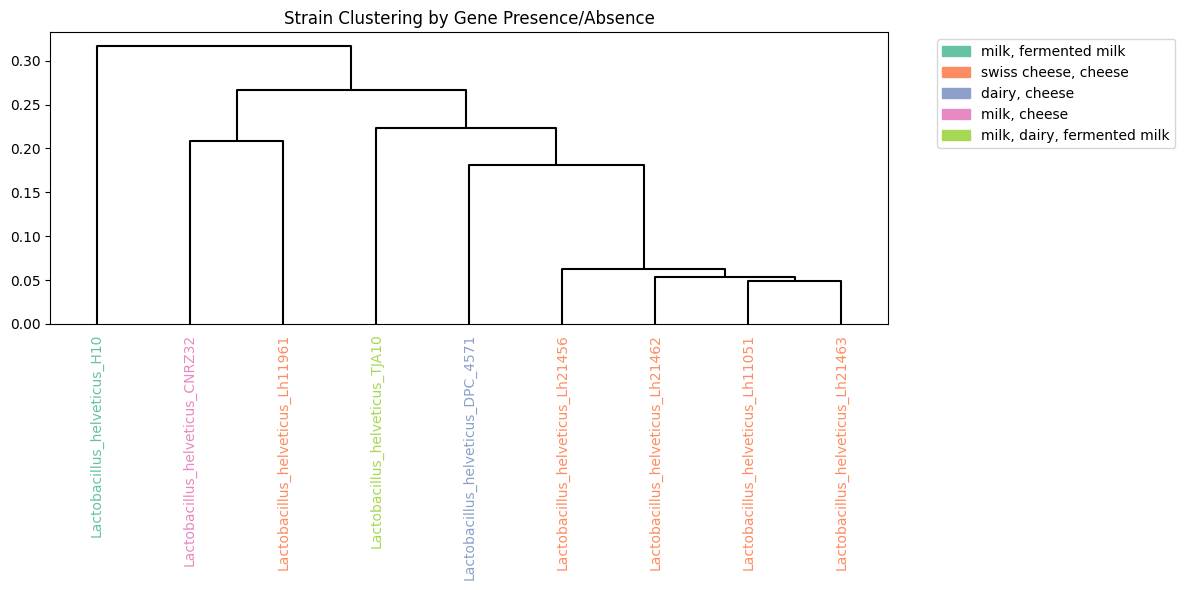

In [16]:
# import matplotlib.patches as mpatches



plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=binary_matrix.columns,
    leaf_rotation=90,
    leaf_font_size=10,
    link_color_func=lambda k: 'black',  # black branches
)

# Color ticks or labels
ax = plt.gca()
xlabs = ax.get_xmajorticklabels()
for lbl in xlabs:
    strain = lbl.get_text()
    lbl.set_color(color_map[cheese_colors[strain]])

handles = [mpatches.Patch(color=color_map[k], label=k) for k in color_map]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Strain Clustering by Gene Presence/Absence")
plt.tight_layout()
plt.show()

[Swiss Cheese Paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC11452379/pdf/41467_2024_Article_52687.pdf)

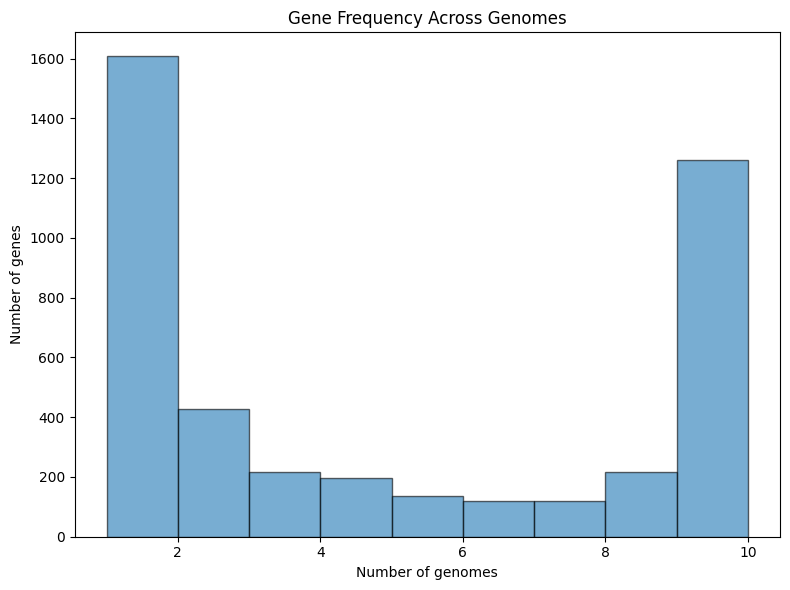

In [17]:
# Identify strain columns
strain_cols = [col for col in gpa.columns if col.startswith("Lactobacillus") or col in gpa.columns[14:]]

# Binary matrix of gene presence (1) / absence (0)
binary_matrix = gpa[strain_cols].notna().astype(int)

# Count in how many genomes each gene is present
gene_counts = binary_matrix.sum(axis=1)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(gene_counts, bins=range(1, len(strain_cols)+2), edgecolor='k', alpha=0.6)
plt.xlabel("Number of genomes")
plt.ylabel("Number of genes")
plt.title("Gene Frequency Across Genomes")
plt.tight_layout()
plt.show()


# 2. H10 strain

In [18]:
# === Identify strain columns ===
strain_cols = [col for col in gpa.columns if col in meta['short_name'].values]
gene_matrix = gpa[strain_cols].notna().astype(int)

# === 1. Unique genes for H10 ===
h10_strain = meta[meta['short_name'].str.contains("H10", case=False, na=False)]['short_name'].values[0]
unique_h10_idx = (gene_matrix[h10_strain] == 1) & (gene_matrix.drop(columns=[h10_strain]).sum(axis=1) == 0)
unique_h10_genes = gpa.loc[unique_h10_idx, "Gene"].dropna().tolist()

In [19]:
len(unique_h10_genes)

475

In [20]:
# select EggNog mapper annotation for genes soecific to H10 strain
eggnog_h10 = eggnog[eggnog.Gene.isin(unique_h10_genes)]

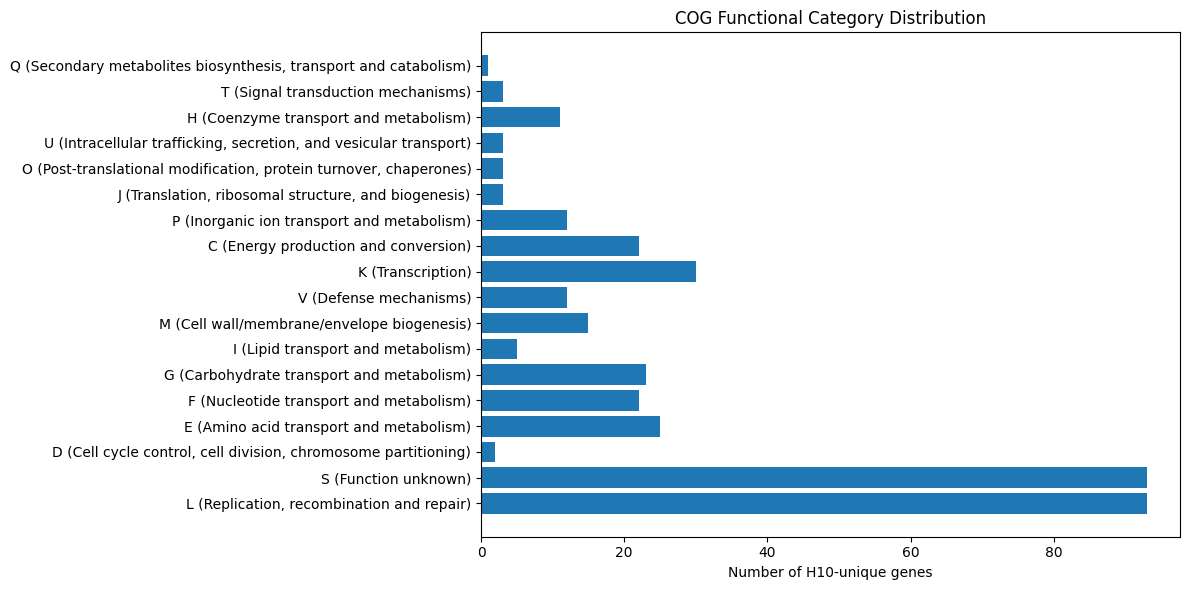

In [21]:
# Standard COG category descriptions (one-letter code: meaning)
cog_descriptions = {
    'J': 'Translation, ribosomal structure, and biogenesis',
    'A': 'RNA processing and modification',
    'K': 'Transcription',
    'L': 'Replication, recombination and repair',
    'B': 'Chromatin structure and dynamics',
    'D': 'Cell cycle control, cell division, chromosome partitioning',
    'Y': 'Nuclear structure',
    'V': 'Defense mechanisms',
    'T': 'Signal transduction mechanisms',
    'M': 'Cell wall/membrane/envelope biogenesis',
    'N': 'Cell motility',
    'Z': 'Cytoskeleton',
    'W': 'Extracellular structures',
    'U': 'Intracellular trafficking, secretion, and vesicular transport',
    'O': 'Post-translational modification, protein turnover, chaperones',
    'C': 'Energy production and conversion',
    'G': 'Carbohydrate transport and metabolism',
    'E': 'Amino acid transport and metabolism',
    'F': 'Nucleotide transport and metabolism',
    'H': 'Coenzyme transport and metabolism',
    'I': 'Lipid transport and metabolism',
    'P': 'Inorganic ion transport and metabolism',
    'Q': 'Secondary metabolites biosynthesis, transport and catabolism',
    'R': 'General function prediction only',
    'S': 'Function unknown'
}

# Expand multi-letter COG categories
cog_series = eggnog_h10['COG_category'].dropna().astype(str)
all_cogs = [c for cat in cog_series for c in cat if c in cog_descriptions]
cog_counts = Counter(all_cogs)

# Prepare data for plotting
labels = [f"{c} ({cog_descriptions[c]})" for c in cog_counts.keys()]
values = [cog_counts[c] for c in cog_counts]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(labels, values)
plt.xlabel("Number of H10-unique genes")
plt.title("COG Functional Category Distribution")
plt.tight_layout()
plt.show()


In [22]:

#### QUICK SEARCH FOR CANDIDATE GENES RELATED TO FERMENTATION THAT ARE SPECIFIC TO THE H10 STRAIN ####

# Define keywords associated with milk fermentation functions
keywords = ['lactose', 'galactose', 'beta-galactosidase', 'peptidase', 'protease',
             'amino acid',
            'casein', 'dipeptidyl']

# Search for these keywords in the Description field
matches = eggnog_h10[eggnog_h10['Description'].str.contains('|'.join(keywords), case=False, na=False)]

# Select relevant columns for review
milk_ferment_related = matches[[
    'query_name', 'Preferred_name', 'Description', 'COG_category', 'KEGG_ko', 'KEGG_Pathway', 'GOs'
]]



In [23]:
milk_ferment_related

,query_name,Preferred_name,Description,COG_category,KEGG_ko,KEGG_Pathway,GOs
2761,c8b8aac069fa36cfcc7e4f9a83d2e35b_524,prtB,Belongs to the peptidase S8 family,O,ko:K01361,-,-
2784,c8b8aac069fa36cfcc7e4f9a83d2e35b_622,-,Peptidase family M1 domain,M,-,-,-
2807,c8b8aac069fa36cfcc7e4f9a83d2e35b_720,lacZ,-beta-galactosidase,G,ko:K12308,"ko00052,map00052",-
2822,c8b8aac069fa36cfcc7e4f9a83d2e35b_752,potE,Amino Acid,E,-,-,-
2931,c8b8aac069fa36cfcc7e4f9a83d2e35b_1144,steT,amino acid,E,ko:K03294,-,"GO:0003333,GO:0003674,GO:0005215,GO:0005342,GO..."
2932,c8b8aac069fa36cfcc7e4f9a83d2e35b_1149,prtP,Belongs to the peptidase S8 family,O,ko:K01361,-,-
3089,c8b8aac069fa36cfcc7e4f9a83d2e35b_1946,-,Peptidase propeptide and YPEB domain,S,-,-,-
3139,c8b8aac069fa36cfcc7e4f9a83d2e35b_2118,pepD4,Dipeptidase,E,ko:K08659,-,-


# 3. Quick check on genes encoding peptidases


In [24]:
# Build strain → cheese type mapping
cheese_map = dict(zip(meta['short_name'], meta['Cheese Type(s)']))

# Expand present_in_strains to include cheese types
def map_strains_to_cheese(row):
    strains = row['present_in_strains']
    return [cheese_map.get(s, 'Unknown') for s in strains]

In [25]:
# Look for peptidase genes
peptidase_genes = gpa[gpa['Annotation'].fillna('').str.contains('peptidase', case=False)]

# Identify strain columns
strain_cols = [col for col in gpa.columns if col.startswith('Lactobacillus')]

# Count how many strains each gene is present in
peptidase_genes['num_strains'] = peptidase_genes[strain_cols].notna().sum(axis=1)


<ipython-input-25-1dd4ce655b94>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peptidase_genes['num_strains'] = peptidase_genes[strain_cols].notna().sum(axis=1)


In [26]:
# Classify as core or accessory
total_strains = len(strain_cols)
peptidase_genes['core_or_accessory'] = peptidase_genes['num_strains'].apply(
    lambda x: 'core' if x == total_strains else 'accessory'
)


<ipython-input-26-429be37b384c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peptidase_genes['core_or_accessory'] = peptidase_genes['num_strains'].apply(


In [27]:
# Add list of strains where gene is present
peptidase_genes['present_in_strains'] = peptidase_genes[strain_cols].apply(
    lambda row: [strain for strain in strain_cols if pd.notna(row[strain])], axis=1
)

# Show selected columns
peptidase_summary = peptidase_genes[['Gene',
                                     'Annotation', 'num_strains',
                                     'core_or_accessory', 'present_in_strains']]


# Add cheese info
peptidase_summary['cheese_type_present_in'] = peptidase_summary.apply(map_strains_to_cheese, axis=1)


<ipython-input-27-28b032b047ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peptidase_genes['present_in_strains'] = peptidase_genes[strain_cols].apply(
<ipython-input-27-28b032b047ab>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peptidase_summary['cheese_type_present_in'] = peptidase_summary.apply(map_strains_to_cheese, axis=1)


In [28]:
pd.set_option('max_colwidth', 50) # regulate columns width

peptidase_summary

,Gene,Annotation,num_strains,core_or_accessory,present_in_strains,cheese_type_present_in
81,group_1276,Neutral endopeptidase,9,core,"[Lactobacillus_helveticus_CNRZ32, Lactobacillu...","[milk, cheese, dairy, cheese, milk, fermented ..."
109,pepC,Aminopeptidase C,9,core,"[Lactobacillus_helveticus_CNRZ32, Lactobacillu...","[milk, cheese, dairy, cheese, milk, fermented ..."
135,pip,Proline iminopeptidase,9,core,"[Lactobacillus_helveticus_CNRZ32, Lactobacillu...","[milk, cheese, dairy, cheese, milk, fermented ..."
263,spsB_1,Signal peptidase IB,9,core,"[Lactobacillus_helveticus_CNRZ32, Lactobacillu...","[milk, cheese, dairy, cheese, milk, fermented ..."
292,pepX,Xaa-Pro dipeptidyl-peptidase,9,core,"[Lactobacillus_helveticus_CNRZ32, Lactobacillu...","[milk, cheese, dairy, cheese, milk, fermented ..."
452,pepE_3,Aminopeptidase E,9,core,"[Lactobacillus_helveticus_CNRZ32, Lactobacillu...","[milk, cheese, dairy, cheese, milk, fermented ..."
478,spsB_2,Signal peptidase IB,9,core,"[Lactobacillus_helveticus_CNRZ32, Lactobacillu...","[milk, cheese, dairy, cheese, milk, fermented ..."
482,fpaP,Proline iminopeptidase,9,core,"[Lactobacillus_helveticus_CNRZ32, Lactobacillu...","[milk, cheese, dairy, cheese, milk, fermented ..."
555,map,Methionine aminopeptidase 1,9,core,"[Lactobacillus_helveticus_CNRZ32, Lactobacillu...","[milk, cheese, dairy, cheese, milk, fermented ..."
568,pepE_2,Aminopeptidase E,9,core,"[Lactobacillus_helveticus_CNRZ32, Lactobacillu...","[milk, cheese, dairy, cheese, milk, fermented ..."


# 4. Get genes that might be related to development of a cheese flavour and texture

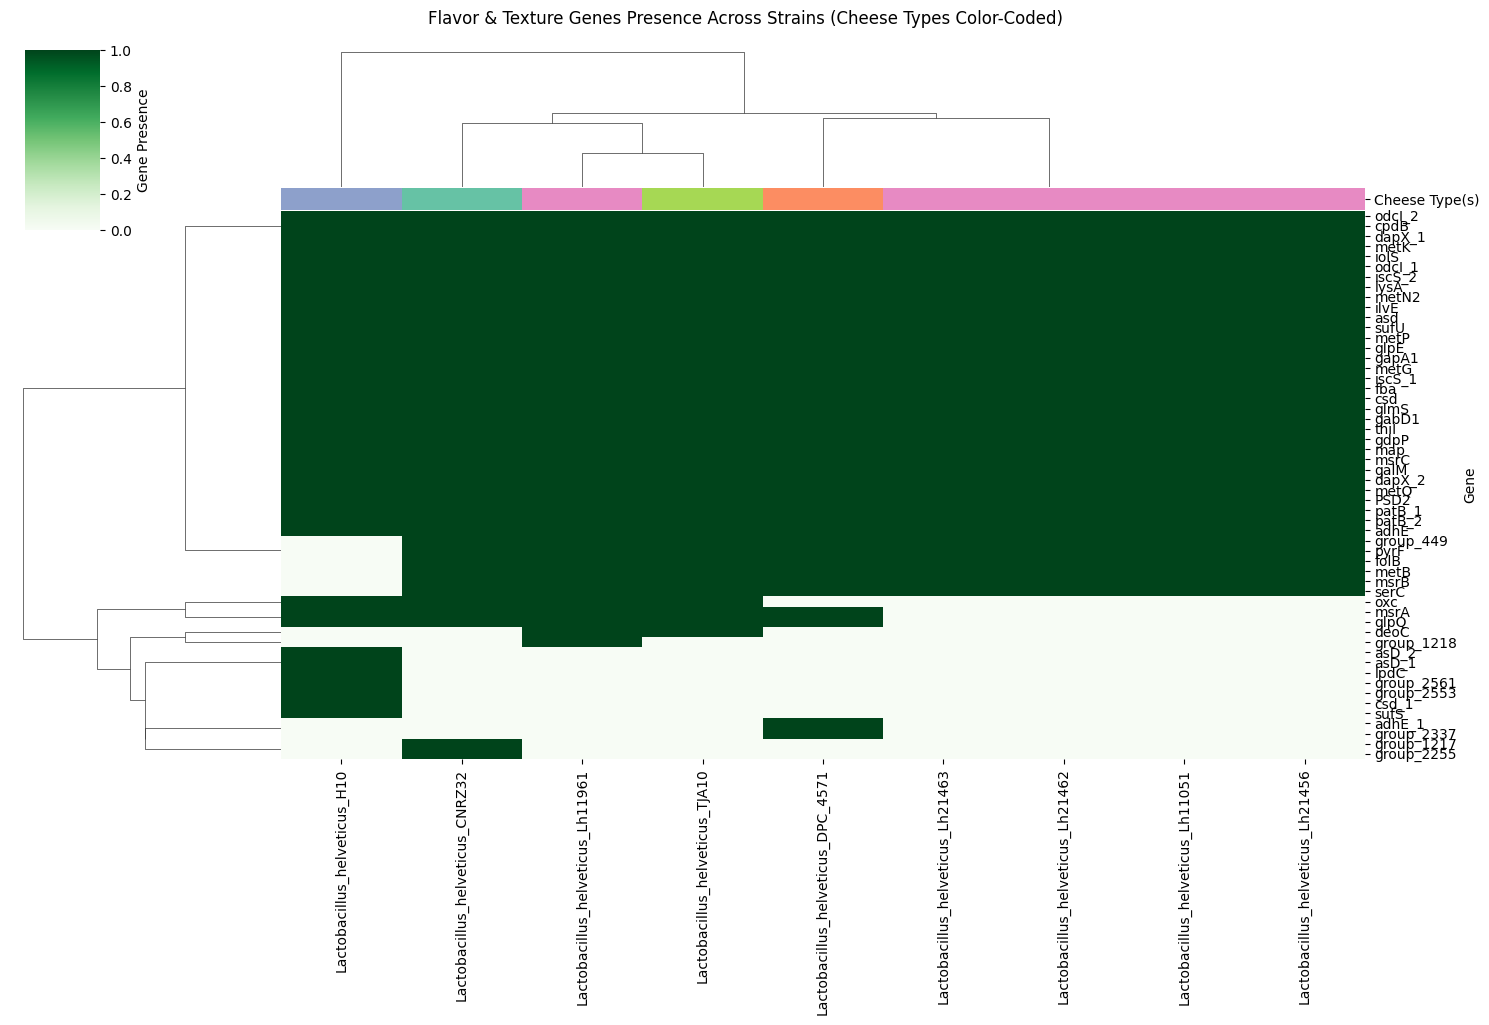

In [29]:
# === 1. Filter flavor-related genes ===
flavor_keywords = [
    'aminotransferase', 'methionine', 'cystathionine', 'decarboxylase',
    'sulfur', 'aroma', 'lipase', 'esterase', 'ald', 'tnaA', 'cysK', 'metC', 'ilvE', 'tyrB'
]

flavor_genes = gpa[gpa['Annotation'].fillna('').str.contains('|'.join(flavor_keywords), case=False)]

# === 2. Create binary matrix ===
binary_matrix = flavor_genes[strain_cols].notna().astype(int)
binary_matrix.index = flavor_genes['Gene'] # Use gene ID as index

# === 3. Add cheese type labels to strains ===
strain_cheese_type = meta.set_index('short_name')['Cheese Type(s)'].fillna("Unknown")
column_colors = strain_cheese_type.loc[binary_matrix.columns]

# Convert to colors for heatmap (optional step)
cheese_palette = {
    c: color for c, color in zip(column_colors.unique(), sns.color_palette("Set2", len(column_colors.unique())))
}
column_colors_mapped = column_colors.map(cheese_palette)

# === 4. Plot heatmap ===
sns.clustermap(
    binary_matrix,
    figsize=(15, 10),
    cmap="Greens",
    col_colors=column_colors_mapped,
    yticklabels=True,
    xticklabels=True,
    cbar_kws={"label": "Gene Presence"}
)

plt.suptitle("Flavor & Texture Genes Presence Across Strains (Cheese Types Color-Coded)", y=1.02)
plt.show()

# 5. Get genes that are enriched in swiss cheese strains




In [30]:
# Intersect strains from both files
strain_cols = [col for col in gpa.columns if col in meta['short_name'].values]
# meta_filtered = meta[meta['short_name'].isin(strain_cols)]
cheese_map = dict(zip(meta['short_name'], meta['Cheese Type(s)'].fillna("Unknown")))

In [31]:
cheese_map


{'Lactobacillus_helveticus_DPC_4571': 'dairy, cheese',
 'Lactobacillus_helveticus_H10': 'milk, fermented milk',
 'Lactobacillus_helveticus_CNRZ32': 'milk, cheese',
 'Lactobacillus_helveticus_TJA10': 'milk, dairy, fermented milk',
 'Lactobacillus_helveticus_Lh21462': 'swiss cheese, cheese',
 'Lactobacillus_helveticus_Lh21463': 'swiss cheese, cheese',
 'Lactobacillus_helveticus_Lh11961': 'swiss cheese, cheese',
 'Lactobacillus_helveticus_Lh11051': 'swiss cheese, cheese',
 'Lactobacillus_helveticus_Lh21456': 'swiss cheese, cheese'}

In [32]:
# Identify Swiss cheese strains
swiss_strains = meta[meta['Cheese Type(s)'].str.contains("swiss", case=False, na=False)]['short_name'].values
swiss_matrix = gpa[swiss_strains].notna().astype(int)
non_swiss_strains = [s for s in strain_cols if s not in swiss_strains]
non_swiss_matrix = gpa[non_swiss_strains].notna().astype(int)


In [33]:
# Define swiss-enriched genes
# the gene is present in most (≥80%) of the swiss cheese strains
# the gene is absent in most (≤20%) of the other strains


swiss_enriched_idx = (swiss_matrix.sum(axis=1) >= int(0.8 * len(swiss_strains))) & \
                     (non_swiss_matrix.sum(axis=1) <= int(0.2 * len(non_swiss_strains)))

swiss_enriched_genes = gpa.loc[swiss_enriched_idx, 'Gene']
swiss_enriched_matrix = gpa.loc[swiss_enriched_idx, strain_cols].notna().astype(int)
swiss_enriched_matrix.index = gpa.loc[swiss_enriched_idx, 'Gene']

# Map cheese types to strains
strain_cheese_type = meta.set_index('short_name')['Cheese Type(s)'].fillna("Unknown")
column_colors = strain_cheese_type.loc[swiss_enriched_matrix.columns]

# Assign palette
cheese_palette = {
    c: color for c, color in zip(column_colors.unique(), sns.color_palette("Set2", len(column_colors.unique())))
}
column_colors_mapped = column_colors.map(cheese_palette)

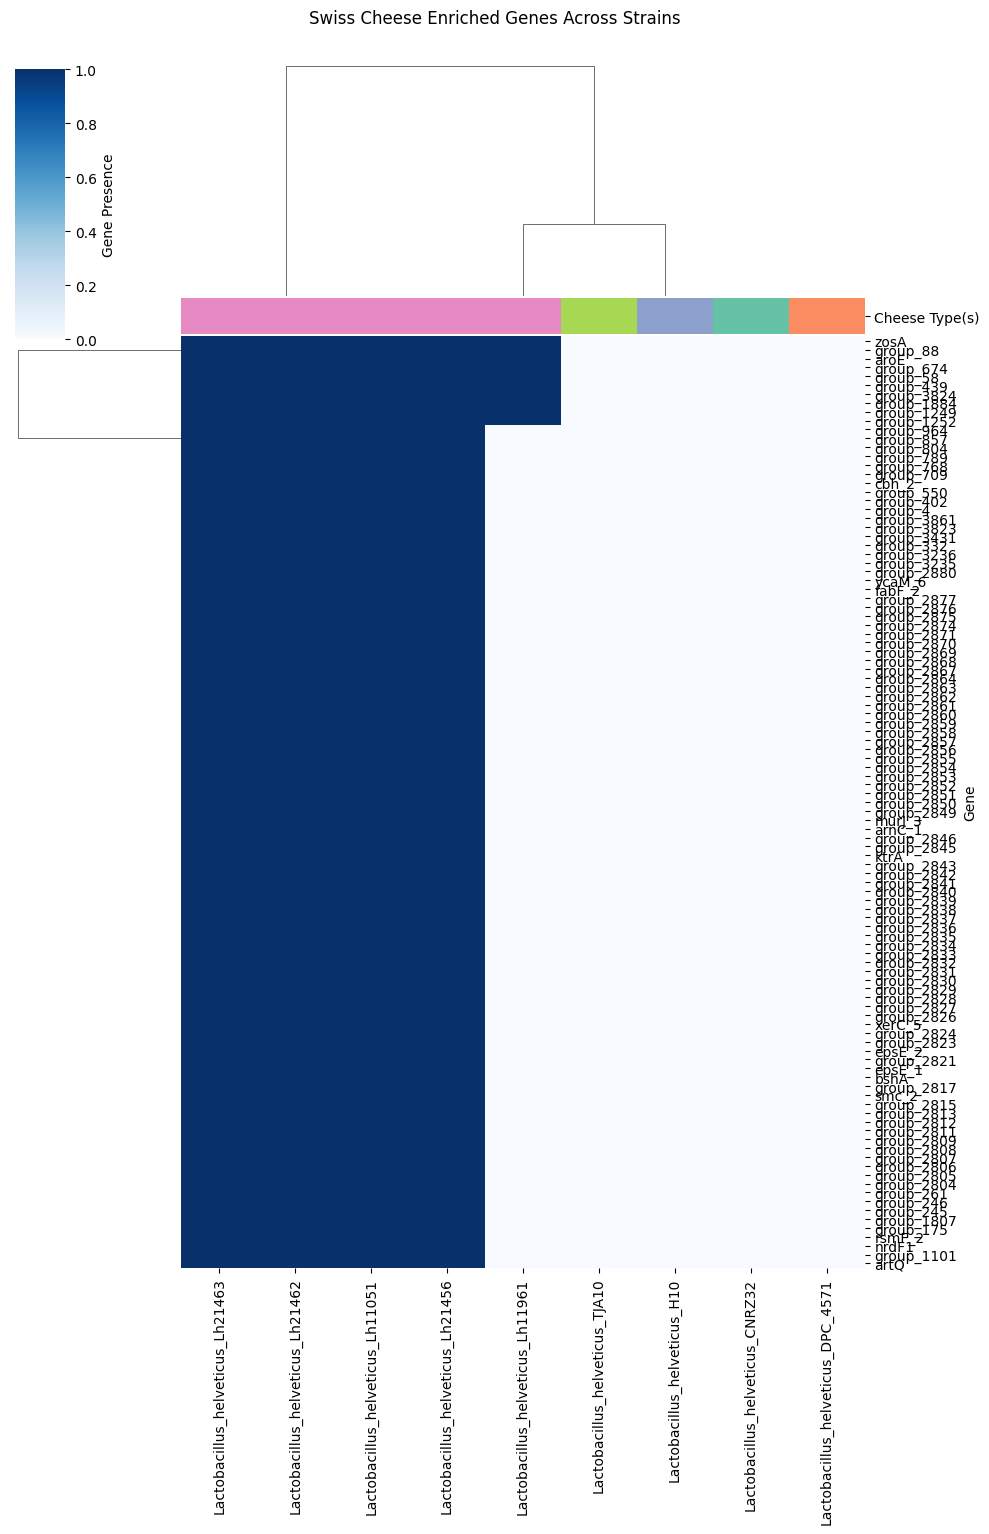

In [34]:
# Plot heatmap
sns.clustermap(
    swiss_enriched_matrix,
    figsize=(10, 15),
    cmap="Blues",
    col_colors=column_colors_mapped,
    yticklabels=True,
    xticklabels=True,
    cbar_kws={"label": "Gene Presence"}
)

plt.suptitle("Swiss Cheese Enriched Genes Across Strains", y=1.02)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


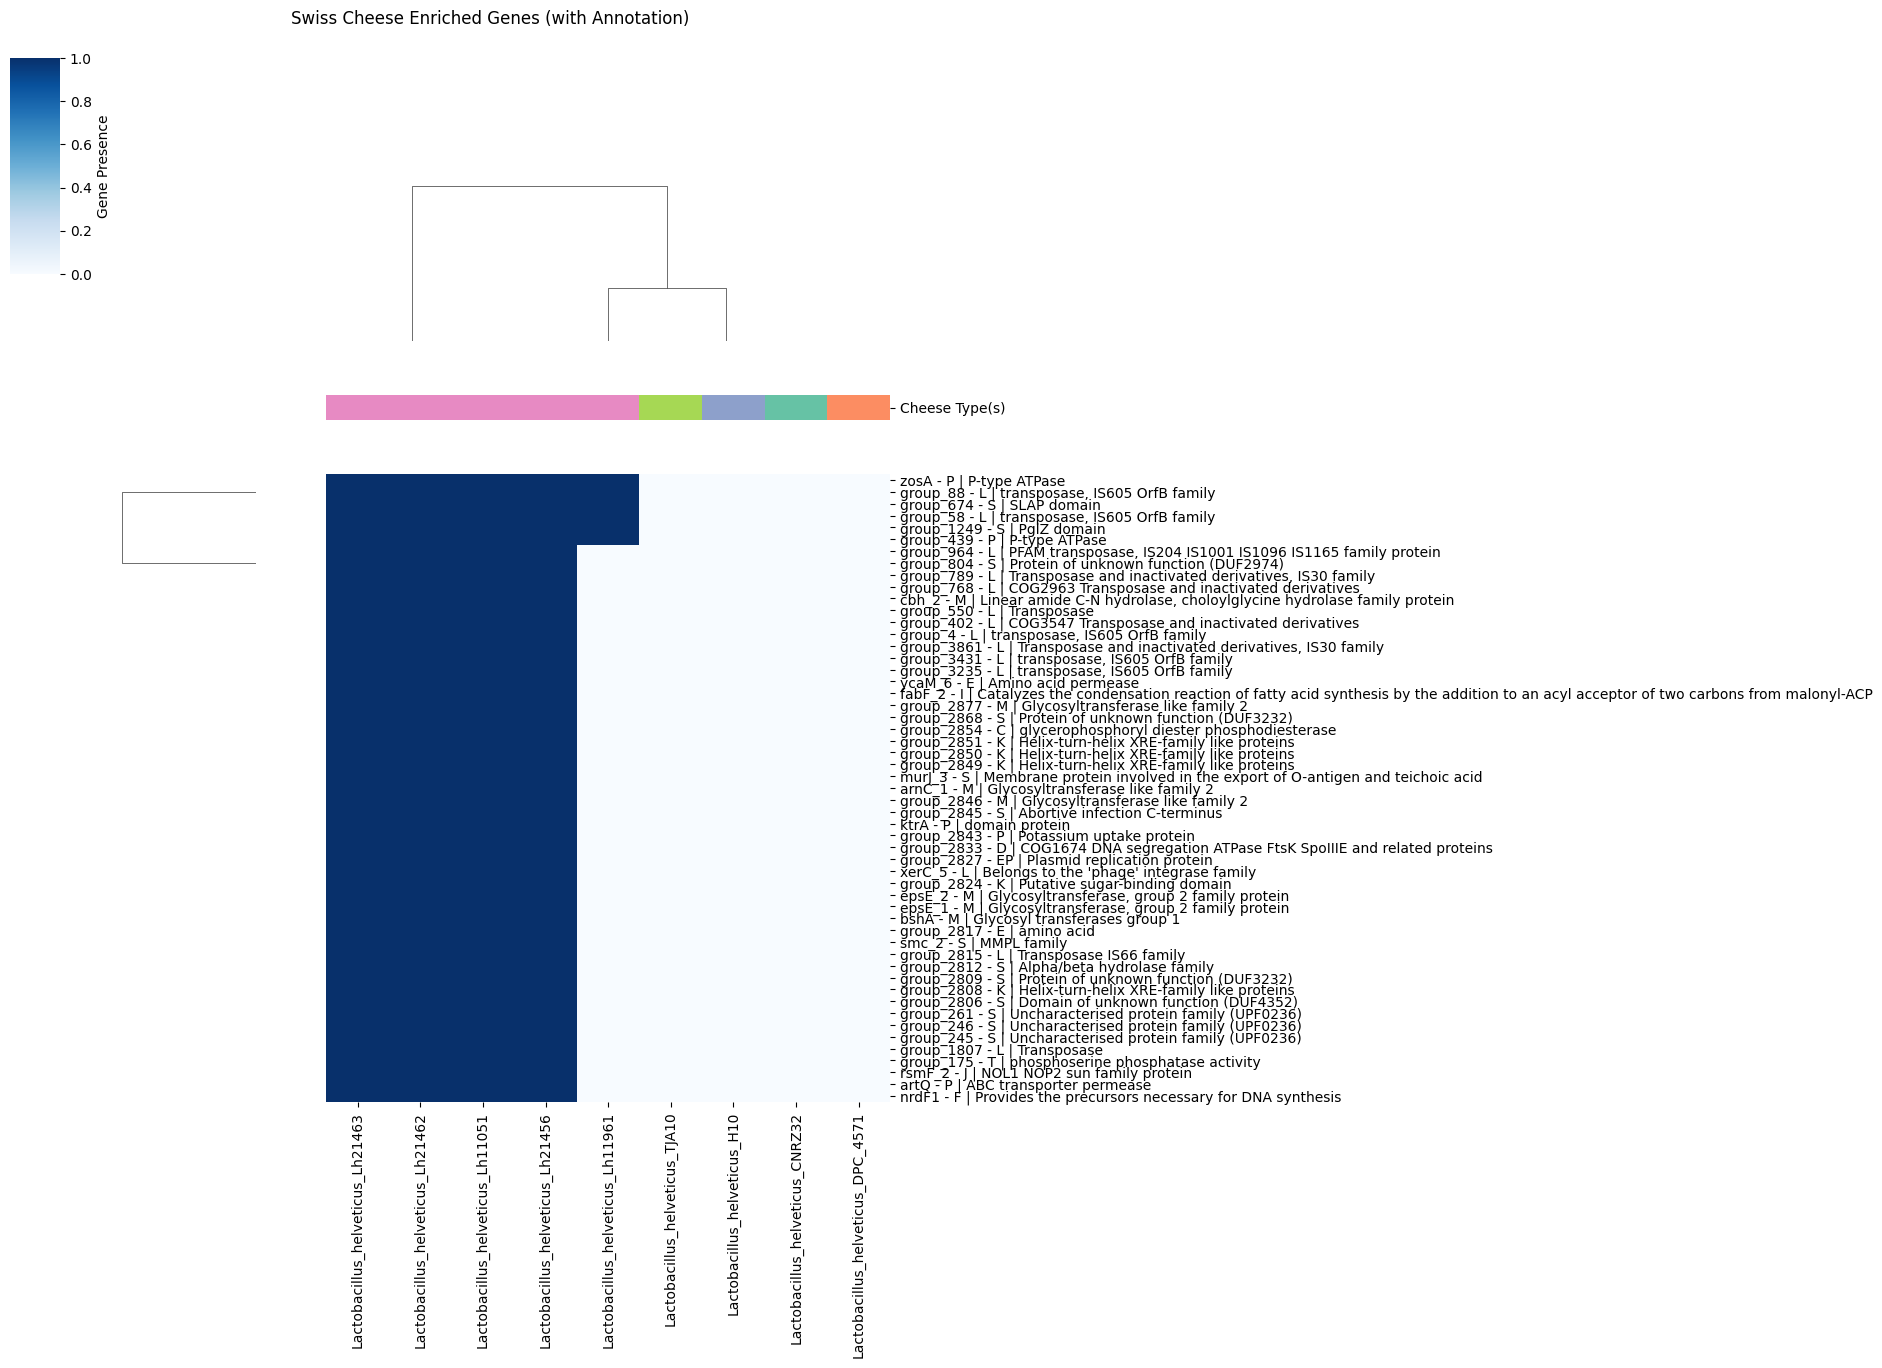

In [35]:
#### #### #### #### #### #### #### ####  #### #### ####
#### LET'S ADD FUNCTIONAL INFO FROM EGGNOME-MAPPER ######
#### #### #### #### #### #### #### ####  #### #### ####

# Merge with gene presence matrix
gene_labels = swiss_enriched_matrix.index.to_series().reset_index(drop=True).to_frame(name='Gene')
gene_labels = gene_labels.merge(eggnog[['Gene', 'COG_descr', 'Description']],
                                how='left', on='Gene')

gene_labels = gene_labels[~((gene_labels.Description.isna()) |\
                             (gene_labels.Description.str.contains('potential problem')) |\
                                (gene_labels.Description == "-") |\
                                    (gene_labels.Description == " "))]

swiss_enriched_matrix = swiss_enriched_matrix.loc[gene_labels.Gene]

# Update row labels in matrix with annotated descriptions (or fallback to gene name)
swiss_enriched_matrix.index = [
    f"{g} - {d}" if pd.notna(d) else g
    for g, d in zip(gene_labels['Gene'], gene_labels['COG_descr'])
]

# Replot heatmap with annotation-enriched row labels
sns.clustermap(
    swiss_enriched_matrix,
    figsize=(10, 12),
    cmap="Blues",
    col_colors=column_colors_mapped,
    yticklabels=True,
    xticklabels=True,
    cbar_kws={"label": "Gene Presence"}
)

plt.suptitle("Swiss Cheese Enriched Genes (with Annotation)", y=1.02)
plt.show()

# Questions

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster


### 1. Cluster bacteria and examine grouping by niche

In [55]:
# Cut dendrogram into clusters
max_clusters = 4  # or choose based on dendrogram
clusters = fcluster(Z, t=max_clusters, criterion='maxclust')
cluster_df = pd.DataFrame({
    'strain': binary_matrix.columns,
    'cluster': clusters,
    'cheese_type': [cheese_colors[s] for s in binary_matrix.columns]
})

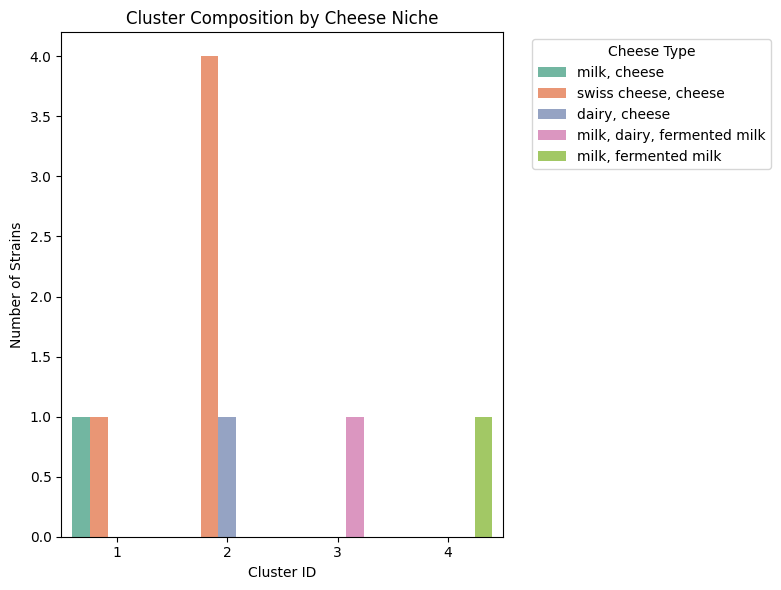

In [56]:
# Plot cluster composition
plt.figure(figsize=(8, 6))
sns.countplot(data=cluster_df, x='cluster', hue='cheese_type', palette=palette)
plt.title('Cluster Composition by Cheese Niche')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Strains')
plt.legend(title='Cheese Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [57]:
# Identify DPC strain cluster
dpc_cluster = cluster_df.loc[cluster_df['strain'].str.contains('DPC'), 'cluster'].iloc[0]
print(f"DPC strain is in cluster {dpc_cluster}, which contains: \n",
      cluster_df[cluster_df['cluster'] == dpc_cluster]['cheese_type'].value_counts())

DPC strain is in cluster 2, which contains: 
 cheese_type
swiss cheese, cheese    4
dairy, cheese           1
Name: count, dtype: int64


### 2. H10-specific genes functional categories

In [58]:
# Count COG categories for H10-unique genes
h10_cogs = eggnog_h10['COG_category'].dropna().str.cat()
h10_cog_counts = Counter([c for c in h10_cogs if c in cog_descriptions])
cog_labels = [f"{c} ({cog_descriptions[c]})" for c in h10_cog_counts]
cog_vals = [h10_cog_counts[c] for c in h10_cog_counts]

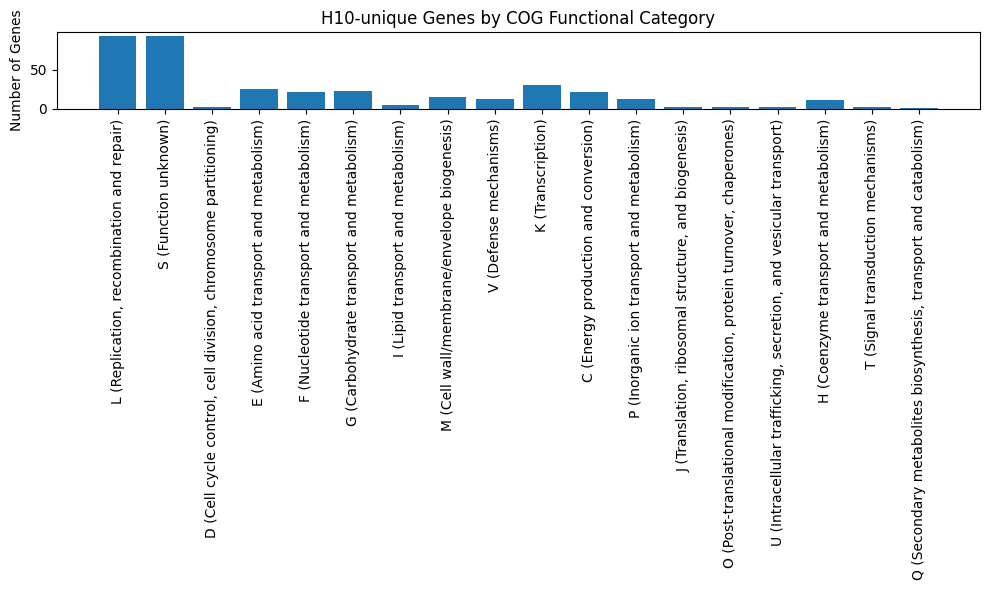

In [59]:
plt.figure(figsize=(10, 6))
plt.bar(cog_labels, cog_vals)
plt.xticks(rotation=90)
plt.title('H10-unique Genes by COG Functional Category')
plt.ylabel('Number of Genes')
plt.tight_layout()
plt.show()

### 3. Milk fermentation candidate genes in H10

In [60]:
print("Milk fermentation-related genes for H10:")
display(milk_ferment_related)

Milk fermentation-related genes for H10:


,query_name,Preferred_name,Description,COG_category,KEGG_ko,KEGG_Pathway,GOs
2761,c8b8aac069fa36cfcc7e4f9a83d2e35b_524,prtB,Belongs to the peptidase S8 family,O,ko:K01361,-,-
2784,c8b8aac069fa36cfcc7e4f9a83d2e35b_622,-,Peptidase family M1 domain,M,-,-,-
2807,c8b8aac069fa36cfcc7e4f9a83d2e35b_720,lacZ,-beta-galactosidase,G,ko:K12308,"ko00052,map00052",-
2822,c8b8aac069fa36cfcc7e4f9a83d2e35b_752,potE,Amino Acid,E,-,-,-
2931,c8b8aac069fa36cfcc7e4f9a83d2e35b_1144,steT,amino acid,E,ko:K03294,-,"GO:0003333,GO:0003674,GO:0005215,GO:0005342,GO..."
2932,c8b8aac069fa36cfcc7e4f9a83d2e35b_1149,prtP,Belongs to the peptidase S8 family,O,ko:K01361,-,-
3089,c8b8aac069fa36cfcc7e4f9a83d2e35b_1946,-,Peptidase propeptide and YPEB domain,S,-,-,-
3139,c8b8aac069fa36cfcc7e4f9a83d2e35b_2118,pepD4,Dipeptidase,E,ko:K08659,-,-


In [61]:
# Potential biomarkers: unique to H10 and linked to fermentation
biomarkers = milk_ferment_related[milk_ferment_related['query_name'].isin(unique_h10_genes)]
print("Candidate H10 biomarkers:")
display(biomarkers)

Candidate H10 biomarkers:


,query_name,Preferred_name,Description,COG_category,KEGG_ko,KEGG_Pathway,GOs


### 4. Peptidase distribution: core vs accessory

In [62]:
print("Peptidase genes core vs accessory:")
print(peptidase_summary['core_or_accessory'].value_counts())

Peptidase genes core vs accessory:
core_or_accessory
core         28
accessory     7
Name: count, dtype: int64


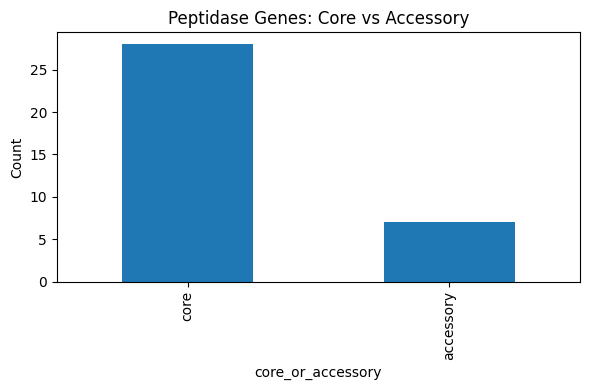

In [63]:
plt.figure(figsize=(6, 4))
peptidase_summary['core_or_accessory'].value_counts().plot(kind='bar')
plt.title('Peptidase Genes: Core vs Accessory')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 5. Flavor/texture enzymes distribution summary

In [64]:
# Count presence across strains
flavor_binary = binary_matrix  # from earlier step for flavor_genes
flavor_counts = flavor_binary.sum(axis=1).sort_values(ascending=False)
flavor_summary = pd.DataFrame({'Gene': flavor_counts.index, 'presence_count': flavor_counts.values})
print("Top flavor/texture enzyme genes by prevalence:")
display(flavor_summary.head(10))

Top flavor/texture enzyme genes by prevalence:


,Gene,presence_count
0,patB_2,9
1,adhE,9
2,patB_1,9
3,PSD2,9
4,metQ,9
5,dapX_2,9
6,galM,9
7,msrC,9
8,map,9
9,gdpP,9


### 6. Swiss cheese enriched genes exploration

In [65]:
# Unique to Swiss: present in all Swiss, absent in all others
unique_swiss = swiss_enriched_genes[swiss_matrix.sum(axis=1) == len(swiss_strains)]
print("Unique genes to Swiss cheese strains:")
print(unique_swiss.tolist())

Unique genes to Swiss cheese strains:
['group_1249', 'group_1252', 'group_1884', 'group_3824', 'group_439', 'group_58', 'group_674', 'aroE', 'group_88', 'zosA']


In [66]:
# Annotate Swiss-enriched genes
swiss_annotations = eggnog[eggnog['Gene'].isin(swiss_enriched_genes)]
gene_func = swiss_annotations[['Gene', 'COG_category', 'COG_descr', 'Description']].drop_duplicates()
print("Functional categories for Swiss-enriched genes:")
display(gene_func)

Functional categories for Swiss-enriched genes:


,Gene,COG_category,COG_descr,Description
3209,group_245,S,S | Uncharacterised protein family (UPF0236),Uncharacterised protein family (UPF0236)
3210,group_246,S,S | Uncharacterised protein family (UPF0236),Uncharacterised protein family (UPF0236)
3212,group_674,S,S | SLAP domain,SLAP domain
3214,group_175,T,T | phosphoserine phosphatase activity,phosphoserine phosphatase activity
3222,group_2805,-,- | -,-
...,...,...,...,...
3354,group_3824,L,L | An automated process has identified a pote...,An automated process has identified a potentia...
3357,ycaM_6,E,E | Amino acid permease,Amino acid permease
3363,group_3861,L,"L | Transposase and inactivated derivatives, I...","Transposase and inactivated derivatives, IS30 ..."
3366,rsmF_2,J,J | NOL1 NOP2 sun family protein,NOL1 NOP2 sun family protein


In [67]:
# Heatmap already plotted; list potential taste-related Swiss genes
taste_keywords = ['aroma', 'flavor', 'sulfur', 'ester', 'lipase']
taste_genes = gene_func[gene_func['Description'].str.contains('|'.join(taste_keywords), case=False, na=False)]
print("Potential taste-formation genes in Swiss strains:")
display(taste_genes)


Potential taste-formation genes in Swiss strains:


,Gene,COG_category,COG_descr,Description
3299,group_2854,C,C | glycerophosphoryl diester phosphodiesterase,glycerophosphoryl diester phosphodiesterase
